<a href="https://colab.research.google.com/github/KiltCross/Character-generator/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf 

print(tf.version)

#!pip install --upgrade tensorflow

from tensorflow.keras import layers

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
import IPython.display as display

import time
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image

import math 

import matplotlib.image as mpimg

In [ ]:
!pip install -q pyyaml h5py

This allow to this notebook to access the drive files

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


This load the saved model

In [ ]:
generator = tf.keras.models.load_model("gdrive/My Drive/Colab Notebooks/Equestria_girls_character_generator/generator.h5")
discriminator = tf.keras.models.load_model("gdrive/My Drive/Colab Notebooks/Equestria_girls_character_generator/discriminator.h5")

Setting the metadata

In [ ]:
def metadata(desire_data, desire_data_of_desire_data=False):
  switcher = {
      'image_shape': [2**7 , 2**6 , 4], #shape of the images ({2**7,2**6,4}={128,64,4})
      'size_of_group_of_data': 244, #size of the groups what the images are diveded in
      'batch_size': 24*2, #total of group of data. (24 for recolor and 2 for swamp)
      'pre_train_discriminator_epoch': 50, #epochs of the discriminador pre-training
      'pre_train_generator_epoch': 100, #epochs of the generador pre-training
      'train_epoch': 1, #epochs of the main training
      'pre_train_batch_size':  1, #quantity of mini batches used to do the pre training (pre main training) training
      'train_batch_size': 1, #quantity of mini batches used to do the training
      'test_batch_size': 1, #quantity of mini batches used to do the testing
      'seed_lenght': 2**7 #it is the lenght of the seed what the generator uses to generate the images
  }
  return switcher.get(desire_data)[desire_data_of_desire_data] if desire_data_of_desire_data else switcher.get(desire_data)

In [ ]:
def image_resize(img, new_shape=[128,64]):
  new_shape = new_shape[:2]
  new_shape[0] , new_shape[1] = new_shape[1], new_shape[0]
  img = Image.fromarray((img*255).astype(np.uint8),"RGBA")
  img = img.resize(new_shape)
  img = np.array(img)/255
  return img

Setting the function what import the databases

In [ ]:
#the ds is divided on groups of 244 images, and the batch size is in units of this groups

def DS(desired_ds='train', batch_size=2*24, train_batch_size = 5, test_batch_size = 1, pre_train_batch_size = 1, size_of_group_of_data=244, image_shape=[128,64,4]):

  train_batch_size = int(train_batch_size * size_of_group_of_data)
  test_batch_size = int(test_batch_size * size_of_group_of_data)
  pre_train_batch_size = int(pre_train_batch_size * size_of_group_of_data)

  last_timing = time.time()
  time_elapsed = 0
  Iteration = 0

  if (desired_ds == 'train'):
    print("Importing main training dataset")
    ds = np.zeros([train_batch_size,image_shape[0],image_shape[1],image_shape[2]], dtype='float32')
    for train_image in range(train_batch_size):

      start = time.time()
      Iteration += 1
      time_left = (time_elapsed/Iteration)*(train_batch_size-Iteration)

      ds[train_image] =  image_resize(mpimg.imread("gdrive/My Drive/Colab Notebooks/Equestria_girls_character_generator/Data_set/"+str(train_image+1)+".png"),image_shape[:2])
      time_elapsed += (start - last_timing)
      print("Image number: "+str(train_image+1)+"/"+str(train_batch_size)+"  |  Time left: "+str(int(time_left/3512))+" hours - "+str(int((time_left%3512)/60))+" minutes - "+str(int(time_left%60))+" seconds  |  Time elapsed: "+str(int(time_elapsed/(60*60)))+" hours - "+str(int(time_elapsed%(60*60)/60))+" minutes - "+str(int(time_elapsed%60))+" seconds")
      
      last_timing = start

    ds = tf.reshape(ds, [train_batch_size,image_shape[0],image_shape[1],image_shape[2]])
    ds = tf.random.shuffle(ds)

  if (desired_ds == 'test'):
    print("Importing test dataset")
    ds = np.zeros([test_batch_size,image_shape[0],image_shape[1],image_shape[2]], dtype='float32')
    for test_image in range(test_batch_size):

      start = time.time()
      Iteration += 1
      time_left = (time_elapsed/Iteration)*(test_batch_size-Iteration)

      ds[test_image] = image_resize(mpimg.imread("gdrive/My Drive/Colab Notebooks/Equestria_girls_character_generator/Data_set/"+str(train_batch_size + test_image+1)+".png"),image_shape[:2])
      time_elapsed += (start - last_timing)
      print("Image number: "+str(test_image+1)+"/"+str(test_batch_size)+"  |  Time left: "+str(int(time_left/3512))+" hours - "+str(int((time_left%3512)/60))+" minutes - "+str(int(time_left%60))+" seconds  |  Time elapsed: "+str(int(time_elapsed/(60*60)))+" hours - "+str(int(time_elapsed%(60*60)/60))+" minutes - "+str(int(time_elapsed%60))+" seconds")

      last_timing = start      

    ds = tf.reshape(ds, [test_batch_size,image_shape[0],image_shape[1],image_shape[2]])
    ds = tf.random.shuffle(ds)


  if (desired_ds == 'pre_train'):
    print("Importing training pre main training dataset")
    ds = np.zeros([pre_train_batch_size,image_shape[0],image_shape[1],image_shape[2]], dtype='float32')
    for pre_train_image in range(pre_train_batch_size):

      start = time.time()
      Iteration += 1
      time_left = (time_elapsed/Iteration)*(pre_train_batch_size-Iteration)      

      image_num = (train_batch_size + test_batch_size) + pre_train_image+1
      ds[pre_train_image] = image_resize(mpimg.imread("gdrive/My Drive/Colab Notebooks/Equestria_girls_character_generator/Data_set/"+str(image_num)+".png"),image_shape[:2])
      time_elapsed += (start - last_timing)
      print("Image number: "+str(pre_train_image+1)+"/"+str(pre_train_batch_size)+"  |  Time left: "+str(int(time_left/3512))+" hours - "+str(int((time_left%3512)/60))+" minutes - "+str(int(time_left%60))+" seconds  |  Time elapsed: "+str(int(time_elapsed/(60*60)))+" hours - "+str(int(time_elapsed%(60*60)/60))+" minutes - "+str(int(time_elapsed%60))+" seconds")

      last_timing = start  

    ds = tf.reshape(ds, [pre_train_batch_size,image_shape[0],image_shape[1],image_shape[2]])
    ds = tf.random.shuffle(ds)
  return ds
  del ds


Model builder

In [ ]:
def generator_model(primary_activation_function=None, semi_final_activation_function='tanh',  final_activation_function='sigmoid', seed_lenght=128, alpha = 0.2, momentum = 0.8, kernel = (4, 4)):

  main_filter=6

  model = tf.keras.Sequential(name="generator")
  
  model.add(layers.Dense(1*1*128, input_shape=(seed_lenght,), use_bias=False, name='Dense_G_1'))
  model.add(layers.LeakyReLU(alpha))
  model.add(layers.BatchNormalization(momentum=momentum))

  model.add(layers.Reshape((1,1,128)))

  model.add(layers.Conv2DTranspose(2**(main_filter+3), kernel_size=kernel, strides=(2, 2), padding='same', use_bias=False, activation=primary_activation_function, name='Conv3DTranspose_G_1'))
  model.add(layers.LeakyReLU(alpha))
  model.add(layers.BatchNormalization(momentum=momentum))

  model.add(layers.Conv2DTranspose(2**(main_filter+2), kernel_size=kernel, strides=(2, 2), padding='same', use_bias=False, activation=primary_activation_function, name='Conv3DTranspose_G_2'))
  model.add(layers.LeakyReLU(alpha))
  model.add(layers.BatchNormalization(momentum=momentum))

  model.add(layers.Conv2DTranspose(2**(main_filter+1), kernel_size=kernel, strides=(2, 2), padding='same', use_bias=False, activation=semi_final_activation_function, name='Conv3DTranspose_G_3'))
  model.add(layers.LeakyReLU(alpha))
  model.add(layers.BatchNormalization(momentum=momentum))

  model.add(layers.Conv2DTranspose(2**(main_filter+0), kernel_size=kernel, strides=(4, 2), padding='same', use_bias=False, activation=semi_final_activation_function, name='Conv3DTranspose_G_4'))
  model.add(layers.LeakyReLU(alpha))
  model.add(layers.BatchNormalization(momentum=momentum))

  model.add(layers.Conv2DTranspose(4, kernel_size=kernel, strides=(4, 4), padding='same', use_bias=False, activation=final_activation_function, name='Conv3DTranspose_G_Final'))


  return model

In [ ]:
def discriminator_model(primary_activation_function=None, semi_final_activation_function=None, final_activation_function='sigmoid', input_shape=[128,64,4], alpha = 0.2, dropout = 0.3, momentum = 0.8, kernel = (4, 4)):

  main_filter=6

  model = tf.keras.Sequential(name="discriminator")

  model.add(layers.Conv2D(2**(main_filter+0), kernel_size=kernel, strides=(2, 2), padding='same', activation=primary_activation_function, name='Conv3D_D_1', input_shape=input_shape))
  model.add(layers.LeakyReLU(alpha))
  model.add(layers.Dropout(dropout))

  model.add(layers.Conv2D(2**(main_filter+1), kernel_size=kernel, strides=(4, 2), padding='same', activation=primary_activation_function, name='Conv3D_D_2'))
  model.add(layers.LeakyReLU(alpha))
  model.add(layers.BatchNormalization(momentum=momentum))
  model.add(layers.Dropout(dropout))

  model.add(layers.Conv2D(2**(main_filter+2), kernel_size=kernel, strides=(4, 4), padding='same', activation=primary_activation_function, name='Conv3D_D_3'))
  model.add(layers.LeakyReLU(alpha))
  model.add(layers.BatchNormalization(momentum=momentum))
  model.add(layers.Dropout(dropout))

  model.add(layers.Conv2D(2**(main_filter+3), kernel_size=kernel, strides=(4, 4), padding='same', activation=semi_final_activation_function, name='Conv3D_D_4'))
  model.add(layers.LeakyReLU(alpha))
  model.add(layers.BatchNormalization(momentum=momentum))
  model.add(layers.Dropout(dropout))

  model.add(layers.Flatten())
  #model.add(layers.Reshape([2**(main_filter+3)]))
  model.add(layers.LeakyReLU(alpha))
  model.add(layers.Dropout(dropout+0.2))
  model.add(layers.Dense(1, activation=final_activation_function, name='Dense_D_Final'))
  #model.add(layers.Flatten())


  return model

Model functionality test:


In [ ]:
generator = generator_model(seed_lenght=metadata("seed_lenght"), primary_activation_function=None, semi_final_activation_function=None, final_activation_function='tanh')

discriminator = discriminator_model(input_shape=metadata("image_shape"), primary_activation_function=None, semi_final_activation_function=None, final_activation_function='sigmoid')

#generator.summary()

#discriminator.summary()


tf.Tensor([[nan]], shape=(1, 1), dtype=float32)


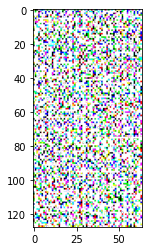

In [ ]:
with tf.device('/CPU:0'):

  seed = tf.random.normal([1,metadata("seed_lenght")])

  generated_image = generator(seed, training=False)

  result = discriminator(generated_image, training=False) 
  
  plt.imshow(generated_image[0,:,:,:])  

  print(result)


Setting some useful varibles

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#loss_function = tf.losses.mean_squared_logarithmic_error
#loss_function = tf.losses.mean_absolute_error

In [ ]:
loss = np.zeros([metadata('train_epoch')*metadata('size_of_group_of_data')*metadata('train_batch_size'),2])
historial = np.zeros([int(metadata('train_epoch')),metadata("image_shape")[0],metadata("image_shape")[1],metadata("image_shape")[2]])
h2 = np.zeros([metadata('train_epoch')*metadata('size_of_group_of_data')*metadata('train_batch_size'),2])

Setting the generator loss

In [ ]:
def generator_loss_function(fake_output):
    return loss_function(tf.ones_like(fake_output), fake_output)

Setting the discriminator loss

In [ ]:
def discriminator_loss_function(real_output, fake_output):
    real_loss = loss_function(tf.subtract(tf.ones_like(real_output),0.1), real_output)
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    total_loss = tf.divide(tf.add(real_loss , fake_loss),2)
    return total_loss

Train function part 1 of 2:

In [ ]:
#@tf.function
def train_step(image, iteration, seed_lenght=128):

    seed = tf.random.normal([1,seed_lenght])
    image = tf.reshape(image, [1,image.shape[0],image.shape[1],image.shape[2]])

    #generator.build([1,seed_lenght])
    #discriminator.build([1,image.shape[0],image.shape[1],image.shape[2],1])

    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:

      generated_image = generator(seed, training=True)

      #This is for evoid an inexplicable shape error
      #generated_image.shape

      real_output = discriminator(image, training=True)
      fake_output = discriminator(generated_image, training=True)
      h2[iteration-1,0] , h2[iteration-1,1] = tf.get_static_value(real_output) , tf.get_static_value(fake_output)

      #generator_loss = loss_function(tf.ones_like(fake_output), fake_output)
      #discriminator_loss = tf.add(loss_function(tf.ones_like(real_output), real_output) , loss_function(tf.zeros_like(fake_output), fake_output))
      generator_loss = generator_loss_function(fake_output)
      discriminator_loss = discriminator_loss_function(real_output,fake_output)
      loss[iteration,0] , loss[iteration,1] = tf.get_static_value(generator_loss) , tf.get_static_value(discriminator_loss)

    #print(discriminator(image))

    gradients_of_discriminator = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    gradients_of_generator = generator_tape.gradient(generator_loss, generator.trainable_variables)

    #gradients_of_discriminator = tf.distribute.get_replica_context().all_reduce('sum', gradients_of_discriminator)
    #gradients_of_generator = tf.distribute.get_replica_context().all_reduce('sum', gradients_of_generator)
     
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    if (int((iteration-1)%(metadata('size_of_group_of_data')*metadata('train_batch_size'))) == 0): historial[int((iteration-1)//(metadata('size_of_group_of_data')*metadata('train_batch_size')))] =  generator(np.ones([1,seed_lenght])*0.5)[0]


Train function part 2 of 2:

In [ ]:
def training_summary(epochs,actual_epoch,batch_size,number_of_image):
  if ((actual_epoch == 0) and (number_of_image == 0)):
    #Setting the variables on the beginning of the loop
    global last_timing 
    global time_elapsed 
    global Iteration 
    global output_lines
    last_timing = time.time()
    time_elapsed = 0
    Iteration = 0
    output_lines = []
  start = time.time()
  Iteration += 1

  #The time calculations
  time_elapsed += (start - last_timing)
  time_left = (time_elapsed/Iteration)*((batch_size*epochs)-Iteration)

  size_of_output_to_be_delete = np.size(output_lines)

  #Adding the actual training summery line
  output_lines.append("Image number: "+str(number_of_image+1)+"/"+str(batch_size)+"  |  Epoch: "+str(actual_epoch+1)+"/"+str(epochs)+"  |  Iteration: "+str(Iteration)+"/"+str(batch_size*epochs)+"  |  Iteration duration: "+str(start - last_timing)+" seconds  |  Time left: "+str(int(time_left/3512))+" hours - "+str(int((time_left%3512)/60))+" minutes - "+str(int(time_left%60))+" seconds  |  Time elapsed: "+str(int(time_elapsed/(60*60)))+" hours - "+str(int(time_elapsed%(60*60)/60))+" minutes - "+str(int(time_elapsed%60))+" seconds | Loss: generator: "+str(loss[Iteration-1,0])+" - discriminator: "+str(loss[Iteration-1,1]))

  #Delete the first line so the display isn't sturated
  if (len(output_lines) > 10):
    del output_lines[0]
  #Delete the previous summery
  size_of_output_to_be_delete = 0
  text_draft_text = "" #This backspace is for the line break made on every 'print' function.
  #This is for get the total lenght of the text.
  for i in range(len(output_lines)):
    size_of_output_to_be_delete += len(output_lines[i])
    text_draft_text = text_draft_text+"\010\010\010\010\010" #Two backspace for the parenthesis on the beginning and end of every line; 
                                                       #two backspace for the quotation marks, one after the parenthesis on the beginning and the other before the parenthesis on the end of every line;
                                                       #and one backspace for every linebreak.
  #This next three line delete the printed text
  for cell in range(size_of_output_to_be_delete):
    text_draft_text = text_draft_text+"\010"
  print(text_draft_text)
  for to_print in range(len(output_lines)):
    print(output_lines[to_print])
  #print(output_lines)
        
  last_timing = start

  #Printing a special end line (on the end of the loop)
  if ((actual_epoch == epochs) and (number_of_image == batch_size)):
    print("Finish!, take: "+str(int(time_elapsed/(60*60)))+":"+str(int(time_elapsed%(60*60)/60))+":"+str(int(time_elapsed%60)))
    del last_timing 
    del time_elapsed 
    del Iteration 
    del output_lines

In [ ]:
def train(images, epochs, seed_lenght=128):


  for epoch in range(epochs):

      for number_of_image in range(images.shape[0]):

        train_step(images[number_of_image],images.shape[0]*(epoch)+number_of_image, seed_lenght)

        training_summary(epochs,epoch,images.shape[0],number_of_image)
      
        


Importing the databases

In [ ]:
pre_train_ds=DS('pre_train',pre_train_batch_size=metadata("pre_train_batch_size"), size_of_group_of_data=metadata("size_of_group_of_data"), image_shape=metadata('image_shape'))

In [ ]:
train_ds=DS('train', train_batch_size=(metadata("train_batch_size")), size_of_group_of_data=metadata("size_of_group_of_data"), image_shape=metadata('image_shape'))

In [ ]:
test_ds=DS('test', test_batch_size=metadata("test_batch_size"), size_of_group_of_data=metadata("size_of_group_of_data"), image_shape=metadata('image_shape'))

Importing test dataset
Image number: 1/244  |  Time left: 0 hours - 0 minutes - 0 seconds  |  Time elapsed: 0 hours - 0 minutes - 0 seconds
Image number: 2/244  |  Time left: 0 hours - 0 minutes - 0 seconds  |  Time elapsed: 0 hours - 0 minutes - 0 seconds
Image number: 3/244  |  Time left: 0 hours - 0 minutes - 42 seconds  |  Time elapsed: 0 hours - 0 minutes - 1 seconds
Image number: 4/244  |  Time left: 0 hours - 1 minutes - 3 seconds  |  Time elapsed: 0 hours - 0 minutes - 1 seconds
Image number: 5/244  |  Time left: 0 hours - 1 minutes - 15 seconds  |  Time elapsed: 0 hours - 0 minutes - 2 seconds
Image number: 6/244  |  Time left: 0 hours - 1 minutes - 21 seconds  |  Time elapsed: 0 hours - 0 minutes - 2 seconds
Image number: 7/244  |  Time left: 0 hours - 1 minutes - 27 seconds  |  Time elapsed: 0 hours - 0 minutes - 3 seconds
Image number: 8/244  |  Time left: 0 hours - 1 minutes - 30 seconds  |  Time elapsed: 0 hours - 0 minutes - 3 seconds
Image number: 9/244  |  Time left: 0

Train test part:

In [ ]:
answer = np.zeros([metadata("pre_train_batch_size")*metadata("size_of_group_of_data")*2, 1], dtype='float32')
#answer = np.ones([metadata("pre_train_batch_size")*metadata("size_of_group_of_data"), 1], dtype='float32')
order = tf.random.shuffle([i for i in range(metadata("pre_train_batch_size")*metadata("size_of_group_of_data")*2)]).numpy()[:metadata("pre_train_batch_size")*metadata("size_of_group_of_data")]
pre_train_ds_shuffled = np.random.normal(size=(metadata("pre_train_batch_size")*metadata("size_of_group_of_data")*2, metadata('image_shape')[0], metadata('image_shape')[1], metadata('image_shape')[2]))
for from_ , to_ in enumerate(order):
  pre_train_ds_shuffled[to_] = pre_train_ds[from_]
  answer[to_,0] = 0.9
#Pre-trainig the discriminator
with tf.device('/GPU:0'), tf.device('/CPU:0'):

  discriminator.compile(optimizer=discriminator_optimizer, loss=tf.keras.losses.mean_absolute_error, metrics=['accuracy'])
  discriminator.fit(x=pre_train_ds_shuffled, y=answer, batch_size=np.shape(pre_train_ds_shuffled)[0], use_multiprocessing=True, epochs=metadata("pre_train_discriminator_epoch"))

In [ ]:
seed = tf.random.normal([metadata("pre_train_batch_size")*metadata("size_of_group_of_data"),metadata("seed_lenght")])
#Pre-trainig the generator
with tf.device('/GPU:0'), tf.device('/CPU:0'):

  generator.compile(optimizer=generator_optimizer, loss=tf.keras.losses.mean_squared_error , metrics=['accuracy'])
  generator.fit(x=seed, y=pre_train_ds, batch_size=(metadata("pre_train_batch_size")*metadata("size_of_group_of_data")), use_multiprocessing=True, epochs=100)

In [ ]:

#fitting the model

with tf.device('/GPU:0'), tf.device('/CPU:0'):

  train(train_ds, metadata("train_epoch"), metadata("seed_lenght"))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'



Image number: 1/244  |  Epoch: 1/1  |  Iteration: 1/244  |  Iteration duration: 2.86102294921875e-06 seconds  |  Time left: 0 hours - 0 minutes - 0 seconds  |  Time elapsed: 0 hours - 0 minutes - 0 seconds | Loss: generator: 0.7495414018630981 - discriminator: 0.7118301391601562


Testing the training

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


8/8 [==============================] - 1s 15ms/step - loss: nan - accuracy: 0.0000e+00
tf.Tensor([[nan]], shape=(1, 1), dtype=float32)
[nan, 0.0]
tf.Tensor([[nan]], shape=(1, 1), dtype=float32)


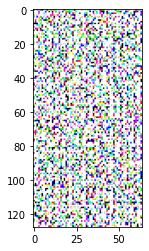

In [ ]:
  discriminator.compile(optimizer=discriminator_optimizer, loss=loss_function, metrics=['accuracy'])

  #test_ds = train_ds[:,:,:,:]6

  seed = tf.random.normal([1,metadata("seed_lenght")])

  anwser = np.ones([metadata("test_batch_size")*metadata("size_of_group_of_data"), 1])

  discriminator_test = train_ds[0]
  discriminator_test = tf.reshape(discriminator_test, [1,metadata("image_shape")[0],metadata("image_shape")[1],metadata("image_shape")[2]])

  generated_image = generator(seed, training=False)

  plt.imshow(generated_image[0,:,:,:]) #print a image generated by the generator

  perspective = discriminator(discriminator_test, training=False)
  test_of_training = discriminator.evaluate(test_ds, np.ones([metadata("pre_train_batch_size")*metadata("size_of_group_of_data")]))
  criterio = discriminator(generated_image, training=False)

  print(perspective) #how the discriminator classifies a image used to train it
  print(test_of_training) #a evaluation of the discriminator with a test database
  print(criterio) #how the dicriminator classifies a image generated by the generator



Saving the trained model

In [ ]:
discriminator.save('gdrive/My Drive/Colab Notebooks/Equestria_girls_character_generator/discriminator.h5')
generator.save('gdrive/My Drive/Colab Notebooks/Equestria_girls_character_generator/generator.h5')

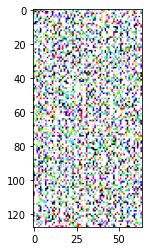

In [ ]:
#ones=tf.ones([1,metadata("seed_lenght")])
seed = tf.random.normal([1,metadata("seed_lenght")])
plt.imshow(generator(seed, training=False)[0,:,:,:])

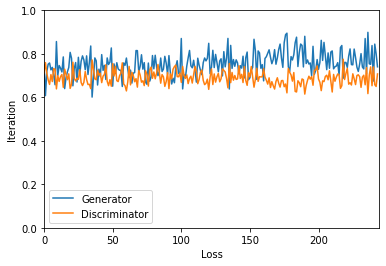

In [ ]:
from_ = 0
to_= np.shape(loss)[0]
plt.figure()
plt.xlabel('Loss')
plt.ylabel('Iteration')
plt.plot(list(range(len(loss[from_:to_,0]))), loss[from_:to_,0], label='Generator')
plt.plot(list(range(len(loss[from_:to_,1]))), loss[from_:to_,1], label='Discriminator')
plt.xlim(0,np.shape(loss)[0])
plt.ylim(0,1)
plt.legend()
plt.show()

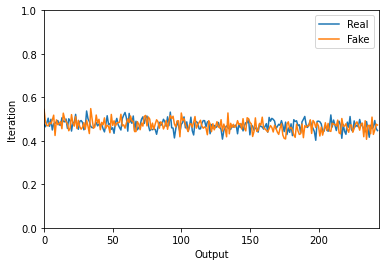

In [ ]:
from_ = 0
to_= np.shape(loss)[0]
plt.figure()
plt.xlabel('Output')
plt.ylabel('Iteration')
plt.plot(list(range(len(h2[from_:to_,0]))), h2[from_:to_,0], label='Real')
plt.plot(list(range(len(h2[from_:to_,1]))), h2[from_:to_,1], label='Fake')
plt.xlim(0,np.shape(h2)[0])
plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
lenght = np.shape(historial)[0]
ideal_number_of_colums = 5
#cou
if (lenght < 4):
  colums = lenght
else:
  colums = ideal_number_of_colums
rows = lenght // ideal_number_of_colums
img = plt.figure(figsize=(2**4,2**3))
for num_img , img in enumerate(historial[:lenght]):
  plt.subplot(rows,colums,num_img+1)
  plt.imshow(img)
  #plt.axis('off')

plt.show()

ValueError: ignored

<Figure size 1152x576 with 0 Axes>

tf.Tensor([0.41028872], shape=(1,), dtype=float32)


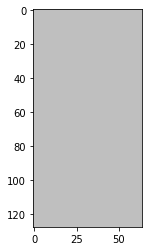

In [ ]:
seed = np.ones([1,128])#tf.random.normal([1,128])
image = tf.random.normal([1,128,64,4])#tf.reshape(train_ds[0], [1,128,64,4])
result_g = generator(seed, training=True)
result_d = discriminator(image, training=True)
#plt.figure(figsize=(32,16))
plt.imshow(result_g[0,:,:,:])
print(result_d[0])

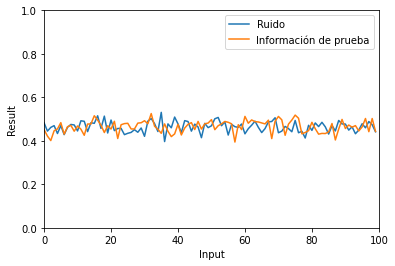

In [ ]:
#discriminator = discriminator_model(input_shape=metadata("image_shape"), primary_activation_function=None, semi_final_activation_function=None, final_activation_function='sigmoid', dropout=0.0, momentum=0.0)
max_long = 100
ruido_discr_prueba = np.zeros([max_long])
ds_discr_prueba = np.zeros([max_long])
for iter in range(max_long):
  #image = np.ones([1,128,64,4])*(iter-max_long)
  ruido_imagen = tf.random.normal([1,128,64,4])
  ds_imagen = tf.reshape(test_ds[iter],[1, test_ds.shape[1],test_ds.shape[2],test_ds.shape[3]])
  ruido_discr_prueba[iter] = discriminator(ruido_imagen, training=True)
  ds_discr_prueba[iter] = discriminator(ds_imagen, training=True)
from_ = 0
to_= max_long
plt.figure()
plt.xlabel('Input')
plt.ylabel('Result')
plt.plot(np.array(list(range(len(ruido_discr_prueba[from_:to_])))), ruido_discr_prueba[from_:to_], label="Ruido")
plt.plot(np.array(list(range(len(ds_discr_prueba[from_:to_])))), ds_discr_prueba[from_:to_], label="Información de prueba")
plt.xlim(0,max_long)
plt.ylim(0,1)
plt.legend()
plt.show()

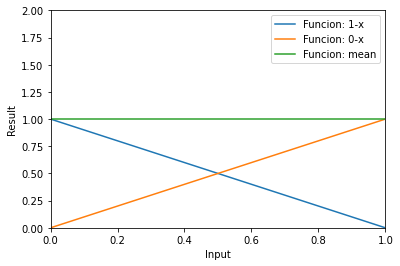

In [ ]:
funcion_de_perdida = tf.keras.losses.mean_absolute_error
largo = 1000
con_negativos = 1 #2 es SI y 1 es NO
numero_de_decimales = 2
numero_de_decimales += 1
y = np.ones([largo*con_negativos,3])
x_chequeo = np.ones([largo*con_negativos])

for x in range(largo*con_negativos):

  y[x,0] = funcion_de_perdida(tf.ones([1]),tf.ones([1])*((x-(largo if (con_negativos == 2) else 0))/10**numero_de_decimales))
  y[x,1] = funcion_de_perdida(tf.ones([1])*(0),tf.ones([1])*((x-(largo if (con_negativos == 2) else 0))/10**numero_de_decimales))
  y[x,2] = (y[x,0] + y[x,1]) / 1

plt.figure()
plt.xlabel('Input')
plt.ylabel('Result')
plt.plot((np.array(list(range(largo*con_negativos)))-(largo if (con_negativos == 2) else 0))/(10**numero_de_decimales), y[:,0], label="Funcion: 1-x")
plt.plot((np.array(list(range(largo*con_negativos)))-(largo if (con_negativos == 2) else 0))/(10**numero_de_decimales), y[:,1], label="Funcion: 0-x")
plt.plot((np.array(list(range(largo*con_negativos)))-(largo if (con_negativos == 2) else 0))/(10**numero_de_decimales), y[:,2], label="Funcion: mean")
plt.xlim(0,1)
plt.ylim(0,2)
plt.legend()
plt.show()

In [ ]:
print("A")
print("AB")
print("\010\010")
#sys.stdout.write("\r")
#import sys


A
AB



In [ ]:
print(output_lines)

['Image number: 138/244  |  Epoch: 1/1  |  Iteration: 138/244  |  Iteration duration: 0.19675540924072266 seconds  |  Time left: 0 hours - 0 minutes - 20 seconds  |  Time elapsed: 0 hours - 0 minutes - 26 seconds | Loss: generator: 0.5978596210479736 - discriminator: 0.7015116214752197', 'Image number: 139/244  |  Epoch: 1/1  |  Iteration: 139/244  |  Iteration duration: 0.18709444999694824 seconds  |  Time left: 0 hours - 0 minutes - 20 seconds  |  Time elapsed: 0 hours - 0 minutes - 26 seconds | Loss: generator: 0.5868117809295654 - discriminator: 0.7097235918045044', 'Image number: 140/244  |  Epoch: 1/1  |  Iteration: 140/244  |  Iteration duration: 0.19291138648986816 seconds  |  Time left: 0 hours - 0 minutes - 19 seconds  |  Time elapsed: 0 hours - 0 minutes - 26 seconds | Loss: generator: 0.587091863155365 - discriminator: 0.7138321399688721', 'Image number: 141/244  |  Epoch: 1/1  |  Iteration: 141/244  |  Iteration duration: 0.18614435195922852 seconds  |  Time left: 0 hours 

In [ ]:
for to_print in range(len(output_lines)):
  print(output_lines[to_print])
size_of_output_to_be_delete = 0
text_draft_text = "" 
#This is for get the total lenght of the text.
for i in range(len(output_lines)):
  size_of_output_to_be_delete += len(output_lines[i])
  text_draft_text = text_draft_text+"\010\010\010\010" #Two backspace for the parenthesis on the beginning and end of every line; 
                                                       #two backspace for the quotation marks, one after the parenthesis on the beginning and the other before the parenthesis on the end of every line;
                                                       #one backspace for every linebreak;
                                                       #and one backspace for the line break made on every 'print' function.
#This next three line delete the printed text
for cell in range(size_of_output_to_be_delete):
  text_draft_text = text_draft_text+"\010"
print(txt)

Image number: 138/244  |  Epoch: 1/1  |  Iteration: 138/244  |  Iteration duration: 0.19675540924072266 seconds  |  Time left: 0 hours - 0 minutes - 20 seconds  |  Time elapsed: 0 hours - 0 minutes - 26 seconds | Loss: generator: 0.5978596210479736 - discriminator: 0.7015116214752197
Image number: 139/244  |  Epoch: 1/1  |  Iteration: 139/244  |  Iteration duration: 0.18709444999694824 seconds  |  Time left: 0 hours - 0 minutes - 20 seconds  |  Time elapsed: 0 hours - 0 minutes - 26 seconds | Loss: generator: 0.5868117809295654 - discriminator: 0.7097235918045044
Image number: 140/244  |  Epoch: 1/1  |  Iteration: 140/244  |  Iteration duration: 0.19291138648986816 seconds  |  Time left: 0 hours - 0 minutes - 19 seconds  |  Time elapsed: 0 hours - 0 minutes - 26 seconds | Loss: generator: 0.587091863155365 - discriminator: 0.7138321399688721
Image number: 141/244  |  Epoch: 1/1  |  Iteration: 141/244  |  Iteration duration: 0.18614435195922852 seconds  |  Time left: 0 hours - 0 minutes

In [ ]:
size_of_output_to_be_delete = 0
for i in range(len(output_lines)):
  size_of_output_to_be_delete += len(output_lines[i])
  print(i)

0
1
2
3
4
5
6
7
8
9
